In [1]:
import sys
import os

# Dodajemy aktualny katalog (root projektu) do ścieżki Pythona
# Dzięki temu zadziała: from src.algorithms...
sys.path.append(os.getcwd())

print("Ścieżka robocza:", os.getcwd())


Ścieżka robocza: /home/edwinh/drone-swarm-simulation


In [2]:
import numpy as np
# Import Twojej klasy problemu (zrefaktoryzowanej)
# Upewnij się, że ścieżka jest poprawna względem folderu src
from src.algorithms.NSGA3.ElementWiseProblem import UAVSwarmPathPlanningProblem 

# --- KONFIGURACJA TESTOWA ---
# 1. Definiujemy przestrzeń i drony
space_limits = [1000, 1000, 100] # Duża przestrzeń
start = [[0, 0, 20]]             # Start: Wysokość 20m
end = [[100, 100, 20]]           # Meta: 100m dalej, ta sama wysokość

# 2. Definiujemy 1 drzewo, które stoi DOKŁADNIE na środku drogi (żeby wymusić kolizję)
# x=50, y=50, promień=10, wysokość=30
# Dron leci z (0,0) do (100,100), więc przeleci przez (50,50). 
# To powinno dać F2 > 0 (kolizja).
obstacles_collision = np.array([[50, 50, 10, 30]]) 

# 3. Definiujemy 1 drzewo Z BOKU (bezpieczne)
# x=50, y=80 (poza trasą)
obstacles_safe = np.array([[50, 80, 10, 30]])

print("Konfiguracja gotowa.")


pybullet build time: Jan 29 2025 23:16:28
/home/edwinh/miniconda3/envs/drone-swarm-env/lib/python3.10/site-packages/gym_pybullet_drones/control/BaseControl.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Konfiguracja gotowa.


In [3]:
# Inicjalizacja problemu (Scenariusz BEZPIECZNY)
problem = UAVSwarmPathPlanningProblem(
    space_limits=space_limits, 
    n_drones=1, 
    n_waypoints=5,  # 5 punktów pośrednich
    start_positions=start, 
    end_positions=end, 
    obstacles=obstacles_safe
)

# Tworzymy idealną linię prostą (Genotyp)
# Genotyp to tylko punkty pośrednie (bez start i end)
t = np.linspace(0, 1, 7)[1:-1] # wartości: 0.16, 0.33, ..., 0.83
start_arr = np.array(start)
end_arr = np.array(end)

# Wektorowa interpolacja: P = Start + t * (End - Start)
# Kształt: (5, 3)
ideal_waypoints = start_arr + t[:, None] * (end_arr - start_arr)

# Spłaszczamy do formatu, którego oczekuje algorytm (N_pop, N_vars)
# Tutaj N_pop = 1
x_ideal = ideal_waypoints.flatten().reshape(1, -1)

# EWALUACJA
out = {}
problem._evaluate(x_ideal, out)

print("=== WYNIKI DLA SCENARIUSZA BEZPIECZNEGO ===")
print(f"F (Cele): {out['F'][0]}")
print(f"   F1 (Długość): {out['F'][0][0]:.2f} m")
print(f"   F2 (Kolizja): {out['F'][0][1]:.2f} (Powinno być 0.0)")
print(f"   F3 (Wysokość): {out['F'][0][2]:.2f} (Powinno być 0.0)")
print("-" * 30)
print(f"G (Ograniczenia): {out['G'][0]}")
print(f"   G1 (Bateria): {out['G'][0][0]:.2f}")
print(f"   G2 (Wysokość min): {out['G'][0][1]:.2f}")
print(f"   G3 (Koordynacja): {out['G'][0][2]:.2f}")

if np.any(out["G"][0] > 0):
    print("\n❌ BŁĄD! Idealna trasa narusza ograniczenia!")
else:
    print("\n✅ SUKCES! Idealna trasa jest poprawna.")


=== WYNIKI DLA SCENARIUSZA BEZPIECZNEGO ===
F (Cele): [141.42135624   0.           0.        ]
   F1 (Długość): 141.42 m
   F2 (Kolizja): 0.00 (Powinno być 0.0)
   F3 (Wysokość): 0.00 (Powinno być 0.0)
------------------------------
G (Ograniczenia): [-282.84271247  -15.          -50.        ]
   G1 (Bateria): -282.84
   G2 (Wysokość min): -15.00
   G3 (Koordynacja): -50.00

✅ SUKCES! Idealna trasa jest poprawna.


In [4]:
# Inicjalizacja problemu (Scenariusz KOLIZYJNY)
problem_collision = UAVSwarmPathPlanningProblem(
    space_limits=space_limits, 
    n_drones=1, 
    n_waypoints=5,
    start_positions=start, 
    end_positions=end, 
    obstacles=obstacles_collision # Drzewo na środku!
)

out_col = {}
problem_collision._evaluate(x_ideal, out_col)

print("=== WYNIKI DLA SCENARIUSZA KOLIZYJNEGO ===")
f2_val = out_col['F'][0][1]
print(f"F2 (Kolizja): {f2_val:.4f}")

if f2_val > 0:
    print("\n✅ SUKCES! Wykryto kolizję z drzewem.")
else:
    print("\n❌ BŁĄD! Dron przeleciał przez drzewo i funkcja zwróciła 0 kary.")


=== WYNIKI DLA SCENARIUSZA KOLIZYJNEGO ===
F2 (Kolizja): 10676.2172

✅ SUKCES! Wykryto kolizję z drzewem.


In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw_cylinder(ax, x, y, r, h, color='red', alpha=0.3):
    """Pomocnicza funkcja rysująca walec (drzewo) w 3D"""
    # Siatka punktów dla walca
    z = np.linspace(0, h, 20)
    theta = np.linspace(0, 2 * np.pi, 20)
    theta_grid, z_grid = np.meshgrid(theta, z)
    
    x_grid = x + r * np.cos(theta_grid)
    y_grid = y + r * np.sin(theta_grid)
    
    # Rysowanie powierzchni
    ax.plot_surface(x_grid, y_grid, z_grid, color=color, alpha=alpha)

def visualize_scenario(problem, x_genotype, title="Wizualizacja Trajektorii"):
    """
    Rysuje trasę drona i przeszkody.
    
    Args:
        problem: Instancja UAVSwarmPathPlanningProblem
        x_genotype: Wektor zmiennych decyzyjnych (1, n_vars)
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 1. Rysowanie Przeszkód (Drzewa)
    print(f"Rysowanie {len(problem.obstacles)} przeszkód...")
    for obs in problem.obstacles:
        x, y, r, h = obs
        draw_cylinder(ax, x, y, r, h)
        
        # Dodaj okrąg na ziemi (rzut)
        theta = np.linspace(0, 2*np.pi, 50)
        xc = x + r * np.cos(theta)
        yc = y + r * np.sin(theta)
        ax.plot(xc, yc, zs=0, color='red', linestyle='--')

    # 2. Rekonstrukcja i Rysowanie Trasy
    # Musimy "ręcznie" skleić trasę, tak jak robi to klasa problemu
    n_drones = problem.n_drones
    n_waypoints = problem.n_waypoints
    
    # Reshape genotypu
    intermediate = x_genotype.reshape(n_drones, n_waypoints, 3)
    
    colors = plt.cm.jet(np.linspace(0, 1, n_drones))
    
    for i in range(n_drones):
        start = problem.start_positions[i]
        end = problem.end_positions[i]
        mid = intermediate[i]
        
        # Sklejanie: Start -> Pośrednie -> End
        # vstack łączy tablice w pionie
        full_path = np.vstack([start, mid, end])
        
        # Rozdzielenie na X, Y, Z do plotowania
        xs = full_path[:, 0]
        ys = full_path[:, 1]
        zs = full_path[:, 2]
        
        # Rysowanie linii
        ax.plot(xs, ys, zs, label=f'Dron {i}', color=colors[i], linewidth=2, marker='o')
        
        # Rysowanie cienia na ziemi (pomaga w ocenie 3D)
        ax.plot(xs, ys, zs=0, color=colors[i], linestyle=':', alpha=0.5)

    # 3. Ustawienia wykresu
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Height [m]')
    ax.set_title(title)
    
    # Ustawienie limitów osi (żeby zachować proporcje)
    # Pobieramy limity z definicji problemu (xu)
    # Zakładamy, że xu jest takie samo dla wszystkich zmiennych, bierzemy pierwsze 3
    # Ale bezpieczniej wziąć space_limits z problemu jeśli je zapamiętaliśmy, 
    # lub po prostu [0, 100] dla tego testu.
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 120)
    ax.set_zlim(0, 60)
    
    plt.legend()
    plt.show()

print("Funkcje wizualizacji załadowane.")


Funkcje wizualizacji załadowane.


Rysowanie 1 przeszkód...


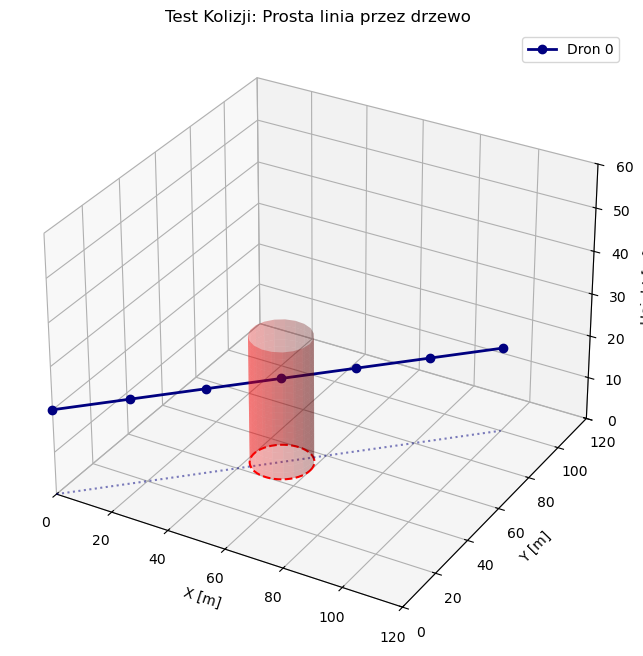

In [7]:
# Używamy obiektu 'problem_collision' i wektora 'x_ideal' z poprzednich kroków
visualize_scenario(problem_collision, x_ideal, title="Test Kolizji: Prosta linia przez drzewo")


=== WYNIKI DLA TRASY OMIJAJĄCEJ ===
F1 (Długość): 152.47 m (Będzie dłuższa niż prosta ~141m)
F2 (Kolizja): 0.0000

✅ SUKCES! Trasa skutecznie ominęła drzewo.
Rysowanie 1 przeszkód...


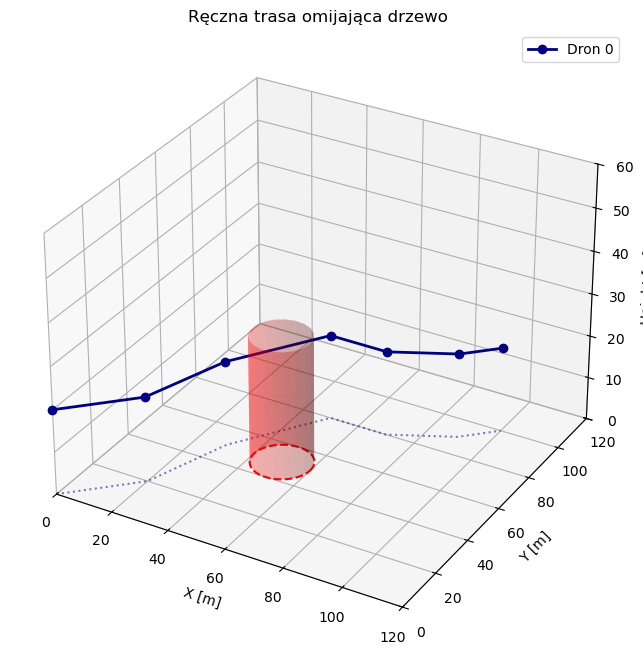

In [7]:
# 1. Definiujemy punkty "ręcznie" (Hardcoded avoidance)
# Start: [0, 0, 20] -> End: [100, 100, 20]
# Drzewo jest na [50, 50]
# Ominiemy je "górą-bokiem" przez punkt [50, 80, 20]

# Tworzymy 5 punktów pośrednich, które tworzą łuk
# P1: Lekko w bok
# P2: Mocno w bok (szczyt łuku)
# P3: Powrót
points_avoid = np.array([
    [20, 20, 20],   # P1
    [30, 50, 20],   # P2
    [50, 80, 20],   # P3 (Kluczowy punkt omijania - daleko od y=50)
    [70, 80, 20],   # P4
    [90, 90, 20]    # P5
])

# Spłaszczamy do formatu genotypu (1, N_vars)
x_avoid = points_avoid.flatten().reshape(1, -1)

# 2. Ewaluacja w "Scenariuszu Kolizyjnym"
out_avoid = {}
problem_collision._evaluate(x_avoid, out_avoid)

print("=== WYNIKI DLA TRASY OMIJAJĄCEJ ===")
f1_len = out_avoid['F'][0][0]
f2_col = out_avoid['F'][0][1]
f3_hgt = out_avoid['F'][0][2]

print(f"F1 (Długość): {f1_len:.2f} m (Będzie dłuższa niż prosta ~141m)")
print(f"F2 (Kolizja): {f2_col:.4f}")

if f2_col == 0:
    print("\n✅ SUKCES! Trasa skutecznie ominęła drzewo.")
else:
    print(f"\n❌ BŁĄD! Nadal kolizja (kara: {f2_col}). Trzeba odsunąć trasę bardziej.")

# 3. Wizualizacja
visualize_scenario(problem_collision, x_avoid, title="Ręczna trasa omijająca drzewo")


Rozpoczynam optymalizację...
Optymalizacja zakończona. Czas: 0.42s
Znaleziono rozwiązań: 5
------------------------------
Najlepsze CV: 0.0 (0.0 oznacza sukces)
Cele (F) tego rozwiązania: [3.39901317e+02 3.02924193e+03 2.88427233e+00]
   Długość: 339.90
   Kolizja: 3029.2419

✅ SUKCES! Algorytm znalazł poprawną trasę.
Rysowanie 1 przeszkód...


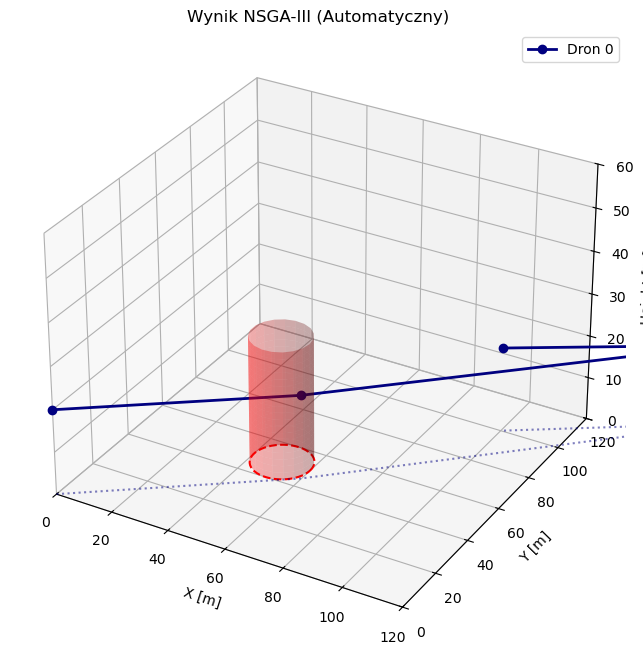

In [14]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.termination import get_termination
import random

# 1. Konfiguracja algorytmu
# Dla 3 celów potrzebujemy kierunków referencyjnych
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# Używamy problemu z kolizją (1 drzewo na środku)
problem_to_solve = problem_collision 

algorithm = NSGA3(
    pop_size=200,          # Większa populacja zwiększa szansę na ominięcie przeszkody
    ref_dirs=ref_dirs,
    n_offsprings=100,
    verbose=True           # Będziemy widzieć postęp w konsoli
)

# Warunek stopu (dajmy mu chwilę - 100 generacji)
termination = get_termination("n_gen", 100)

print("Rozpoczynam optymalizację...")

# 2. Uruchomienie
res = minimize(
    problem_to_solve,
    algorithm,
    termination,
    seed=random.randint(0, 10000),
    save_history=False
)

print(f"Optymalizacja zakończona. Czas: {res.exec_time:.2f}s")
print(f"Znaleziono rozwiązań: {len(res.X) if res.X is not None else 0}")

# 3. Sprawdzenie wyników (Feasible vs Infeasible)
if res.X is not None:
    # Wybierzmy najlepsze rozwiązanie (najmniejsze CV - Constraint Violation)
    # Jeśli CV=0, to rozwiązanie jest poprawne.
    best_idx = np.argmin(res.CV)
    best_X = res.X[best_idx]
    
    print("-" * 30)
    print(f"Najlepsze CV: {res.CV[best_idx][0]} (0.0 oznacza sukces)")
    print(f"Cele (F) tego rozwiązania: {res.F[best_idx]}")
    print(f"   Długość: {res.F[best_idx][0]:.2f}")
    print(f"   Kolizja: {res.F[best_idx][1]:.4f}")
    
    if res.CV[best_idx][0] == 0:
        print("\n✅ SUKCES! Algorytm znalazł poprawną trasę.")
    else:
        print("\n⚠️ OSTRZEŻENIE: Najlepsze rozwiązanie nadal narusza ograniczenia.")
        print("Możliwe przyczyny: za mało generacji, za mała populacja, pechowy seed.")

    # 4. Wizualizacja wyniku
    # Rysujemy to, co wymyśliła sztuczna inteligencja
    visualize_scenario(problem_to_solve, best_X.reshape(1, -1), title="Wynik NSGA-III (Automatyczny)")

else:
    print("Błąd: Algorytm nie zwrócił żadnych wyników (res.X is None).")
